# 전략
* shallow FE 로 피쳐변환한 데이터로 모델링
* deeper FE와 RMSE 비교
* 모델링을 해서 중요한 변수가 뭔지 파악
* SHAP으로 전체 변수 관계 파악

# Load module

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../data/processed/house"))

['df_fe_transformed.pickle', 'house.pkl', 'global_internal_obj_example.pkl', 'local_internal_obj_example.pkl', 'predicted_table.pkl', 'df_shallow_FE_transformed.pickle']


# Load data

In [2]:
import joblib


filename = '../data/processed/house/df_shallow_FE_transformed.pickle'
df = joblib.load(filename)
df.head(3)

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Alley  LotShape  \
0   1           0         0         65.0     8450      0         0   
1   2           1         0         80.0     9600      0         0   
2   3           0         0         68.0    11250      0         1   

   LandContour  LotConfig  LandSlope  ...  Fence  MiscFeature  MiscVal  \
0            0          0          0  ...      0            0        0   
1            0          1          0  ...      0            0        0   
2            0          0          0  ...      0            0        0   

   MoSold  YrSold  SaleType  SaleCondition  SalePrice  MlUse  TotalSF  
0       0       0         0              0  12.247699  train   2566.0  
1       1       1         0              0  12.109016  train   2524.0  
2       2       0         0              0  12.317171  train   2706.0  

[3 rows x 80 columns]

In [4]:
total, colnum = df.shape
print('row cnt = {}, num of columns = {}'.format(total, colnum))

row cnt = 2911, num of columns = 80


# Modeling

In [5]:
df_train = df[df['MlUse']=='train']
df_train.head(3)

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Alley  LotShape  \
0   1           0         0         65.0     8450      0         0   
1   2           1         0         80.0     9600      0         0   
2   3           0         0         68.0    11250      0         1   

   LandContour  LotConfig  LandSlope  ...  Fence  MiscFeature  MiscVal  \
0            0          0          0  ...      0            0        0   
1            0          1          0  ...      0            0        0   
2            0          0          0  ...      0            0        0   

   MoSold  YrSold  SaleType  SaleCondition  SalePrice  MlUse  TotalSF  
0       0       0         0              0  12.247699  train   2566.0  
1       1       1         0              0  12.109016  train   2524.0  
2       2       0         0              0  12.317171  train   2706.0  

[3 rows x 80 columns]

In [6]:
from pycaret.regression import *
reg2 = setup(df_train, target = 'SalePrice', 
             session_id=123, 
             train_size=0.9,
             fold=2,
             log_experiment=True, 
             ignore_features=['Id','MlUse'],
             experiment_name='house2')

In [8]:
best = compare_models(include = ['catboost','lightgbm','xgboost','br','ridge'], fold=2, sort='RMSE')
# best = compare_models()

In [9]:
catboost = create_model('catboost')

In [10]:
import shap


explainer = shap.TreeExplainer(catboost)

In [12]:
get_config('X').head(5)

LotFrontage  LotArea  Neighborhood  YearBuilt  YearRemodAdd  MasVnrArea  \
0         65.0   8450.0           0.0     2003.0        2003.0       196.0   
1         80.0   9600.0           1.0     1976.0        1976.0         0.0   
2         68.0  11250.0           0.0     2001.0        2002.0       162.0   
3         60.0   9550.0           2.0     1915.0        1970.0         0.0   
4         84.0  14260.0           3.0     2000.0        2000.0       350.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_5  \
0       706.0         0.0      150.0        856.0  ...         0.0   
1       978.0         0.0      284.0       1262.0  ...         0.0   
2       486.0         0.0      434.0        920.0  ...         0.0   
3       216.0         0.0      540.0        756.0  ...         0.0   
4       655.0         0.0      490.0       1145.0  ...         0.0   

   SaleType_6  SaleType_7  SaleType_8  SaleCondition_0  SaleCondition_1  \
0         0.0         0.0         0.0              1.0              0.0   
1         0.0         0.0         0.0              1.0              0.0   
2         0.0         0.0         0.0              1.0              0.0   
3         0.0         0.0         0.0              0.0              1.0   
4         0.0         0.0         0.0              1.0              0.0   

   SaleCondition_2  SaleCondition_3  SaleCondition_4  SaleCondition_5  
0              0.0              0.0              0.0              0.0  
1              0.0              0.0              0.0              0.0  
2              0.0              0.0              0.0              0.0  
3              0.0              0.0              0.0              0.0  
4              0.0              0.0              0.0              0.0  

[5 rows x 385 columns]

In [13]:
X = get_config('X')

In [14]:
shap_values = explainer.shap_values(X)

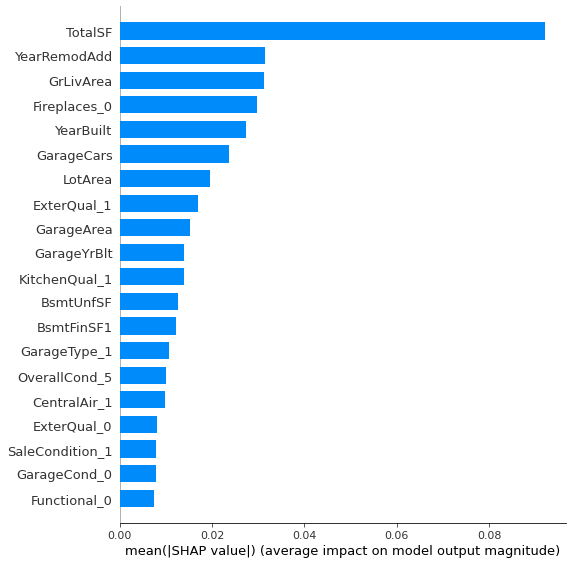

In [15]:
shap.summary_plot(shap_values,X,plot_type="bar",show=False)

In [16]:
np.exp(0.1221)

1.1298670828394555

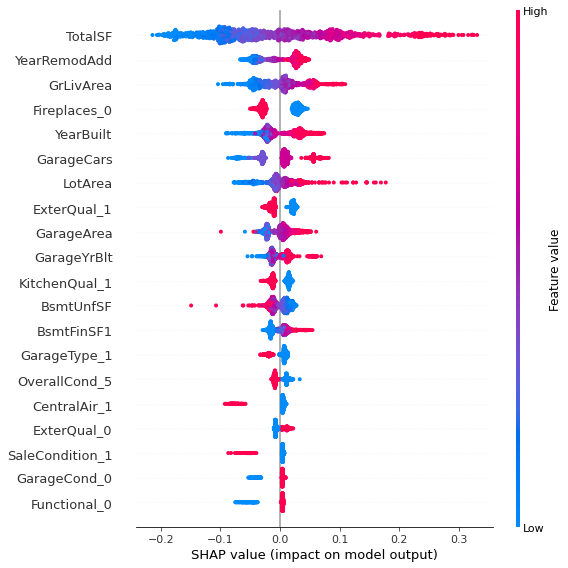

In [17]:
shap.summary_plot(shap_values,X,show=False)

In [18]:
expectation = explainer.expected_value

In [22]:
# house SalePrice의 평균은?
np.expm1(expectation)

166533.32986459232

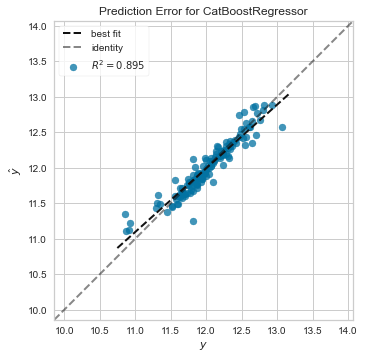

In [23]:
plot_model(catboost, 'error')

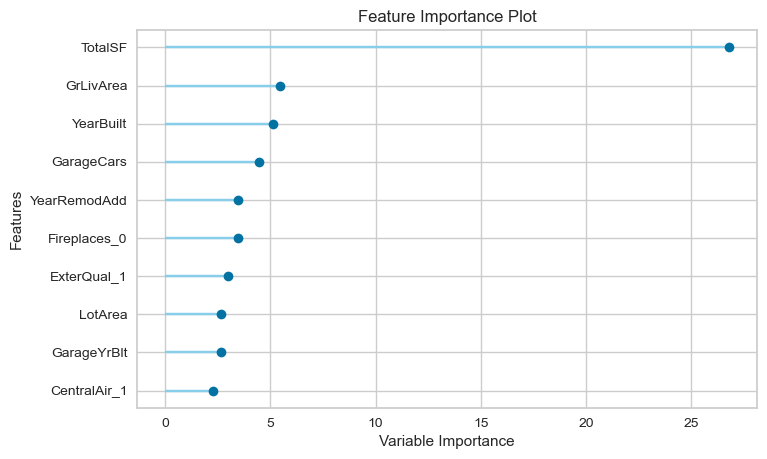

In [24]:
plot_model(catboost, 'feature')

In [25]:
plot_model(catboost, 'parameter')

Parameters
nan_mode                                           Min
eval_metric                                       RMSE
iterations                                        1000
sampling_frequency                             PerTree
leaf_estimation_method                          Newton
grow_policy                              SymmetricTree
penalties_coefficient                                1
boosting_type                                    Plain
model_shrink_mode                             Constant
feature_border_type                       GreedyLogSum
bayesian_matrix_reg                0.10000000149011612
l2_leaf_reg                                          3
random_strength                                      1
rsm                                                  1
boost_from_average                                True
model_size_reg                                     0.5
subsample                            0.800000011920929
use_best_model                                   False
random_seed                                        123
depth                                                6
posterior_sampling                               False
border_count                                       254
classes_count                                        0
auto_class_weights                                None
sparse_features_conflict_fraction                    0
leaf_estimation_backtracking            AnyImprovement
best_model_min_trees                                 1
model_shrink_rate                                    0
min_data_in_leaf                                     1
loss_function                                     RMSE
learning_rate                      0.04095200076699257
score_function                                  Cosine
task_type                                          CPU
leaf_estimation_iterations                           1
bootstrap_type                                     MVS
max_leaves                                          64

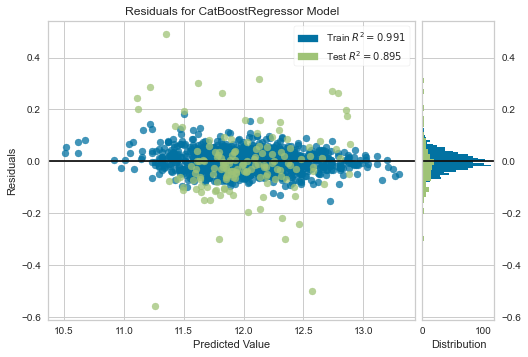

In [26]:
plot_model(catboost, 'residuals')

In [28]:
print('11-->{}'.format(np.expm1(11)))
print('12-->{}'.format(np.expm1(12)))
print('13-->{}'.format(np.expm1(13)))

11-->59873.14171519782
12-->162753.79141900392
13-->442412.3920089205


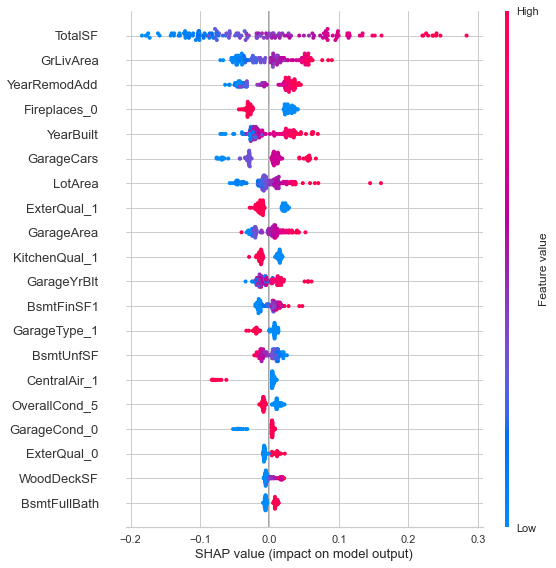

In [29]:
interpret_model(catboost)

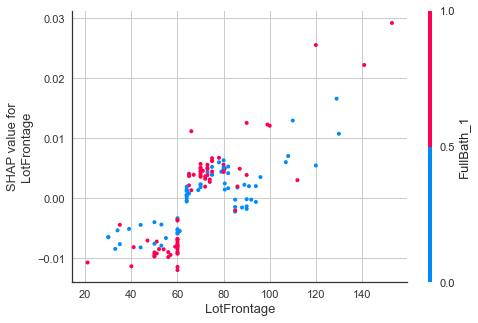

In [30]:
interpret_model(catboost, plot = 'correlation')

In [31]:
interpret_model(catboost, plot = 'reason', observation = 10)

In [32]:
np.expm1(12.74)

341122.54748921306